# Progressive GAN. Reconstrucción de modelos 3D.

En este ejemplo se va a definir una Progressive GAN cuyo objetivo es generar modelos 3D a partir de datos volumétricos.

## Importación de librerías

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Inicialización de datos y parámetros

In [ ]:
LATENT_DIM = 100  # Dimensión del vector de ruido
initial_size = (4, 4, 4, 64)  # Tamaño inicial de la imagen 3D
final_resolution = 32  # Resolución final del modelo

## Implementación del generador

In [ ]:
generator = keras.models.Sequential([
    # Capa de entrada
    layers.Dense(np.prod(initial_size), activation='relu', input_shape=(LATENT_DIM,)),

    # Redimensión de la entrada
    layers.Reshape(initial_size),

    # Primera capa convolucional -> (8x8x8x64)
    layers.Conv3DTranspose(64, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu', use_bias=False),
    layers.BatchNormalization(),

    # Segunda capa convolucional -> (16x16x16x32)
    layers.Conv3DTranspose(32, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu', use_bias=False),
    layers.BatchNormalization(),

    # Tercera capa convolucional -> (32x32x32x16)
    layers.Conv3DTranspose(16, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu', use_bias=False),
    layers.BatchNormalization(),

    # Capa de salida -> (32x32x32x1)
    layers.Conv3DTranspose(1, (3, 3, 3), activation='sigmoid', padding='same')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Resumen del generador
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 4096)                │         413,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 4, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_transpose (Conv3DTranspose)   │ (None, 8, 8, 8, 64)         │         110,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 8, 8, 8, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_transpose_1 (Conv3DTranspose) │ (None, 16, 16, 16, 32)      │          55,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 16, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_transpose_2 (Conv3DTranspose) │ (None, 32, 32, 32, 16)      │          13,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 32, 16)      │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_transpose_3 (Conv3DTranspose) │ (None, 32, 32, 32, 1)       │             433 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 594,289 (2.27 MB)

 Trainable params: 594,065 (2.27 MB)

 Non-trainable params: 224 (896.00 B)

## Implementación del discriminador

In [ ]:
discriminator = keras.models.Sequential([
    # Primera capa convolucional
    layers.Conv3D(8, (3, 3, 3), activation='relu', input_shape=(final_resolution, final_resolution, final_resolution, 1)),

    # Segunda capa convolucional
    layers.Conv3D(16, (3, 3, 3), strides=(2, 2, 2), activation='relu', padding='same'),
    layers.BatchNormalization(),

    # Tercera capa convolucional
    layers.Conv3D(32, (3, 3, 3), strides=(2, 2, 2), activation='relu', padding='same'),
    layers.BatchNormalization(),

    # Cuarta capa convolucional
    layers.Conv3D(64, (3, 3, 3), strides=(2, 2, 2), activation='relu', padding='same'),
    layers.BatchNormalization(),

    # Aplana la salida
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 30, 30, 30, 8)       │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 15, 15, 15, 16)      │           3,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 15, 15, 15, 16)      │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 8, 8, 8, 32)         │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 8, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_3 (Conv3D)                    │ (None, 4, 4, 4, 64)         │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 4, 4, 4, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,457 (302.57 KB)

 Trainable params: 77,233 (301.69 KB)

 Non-trainable params: 224 (896.00 B)

## Entrenamiento de la GAN

In [7]:
# Primeramente inicializamos los optimizadores y funcion de pérdida
generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=False)

Época 1/50
Pérdida del discriminador: 0.14302895963191986, Pérdida del generador: 1.4323803186416626


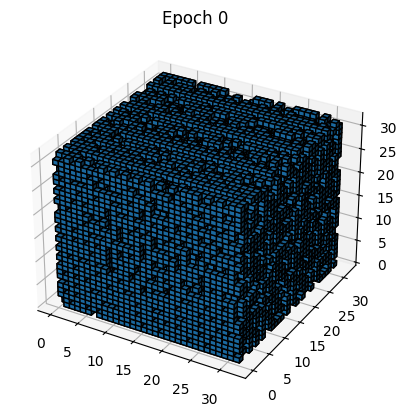

Época 2/50
Pérdida del discriminador: 0.1325829029083252, Pérdida del generador: 1.4413964748382568
Época 3/50
Pérdida del discriminador: 0.20847515761852264, Pérdida del generador: 1.436510443687439
Época 4/50
Pérdida del discriminador: 0.15591074526309967, Pérdida del generador: 1.4500701427459717
Época 5/50
Pérdida del discriminador: 0.2111881971359253, Pérdida del generador: 1.424083948135376
Época 6/50
Pérdida del discriminador: 0.2814718782901764, Pérdida del generador: 1.4238970279693604
Época 7/50
Pérdida del discriminador: 0.28558310866355896, Pérdida del generador: 1.4115186929702759
Época 8/50
Pérdida del discriminador: 0.361820787191391, Pérdida del generador: 1.405421495437622
Época 9/50
Pérdida del discriminador: 0.40066787600517273, Pérdida del generador: 1.394568681716919
Época 10/50
Pérdida del discriminador: 0.5388619303703308, Pérdida del generador: 1.4080605506896973
Época 11/50
Pérdida del discriminador: 0.36677825450897217, Pérdida del generador: 1.435099840164184

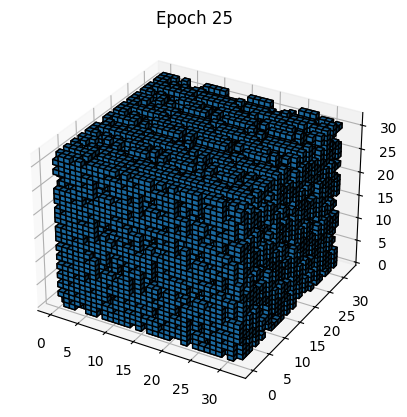

Época 27/50
Pérdida del discriminador: 0.2198631465435028, Pérdida del generador: 1.4746224880218506
Época 28/50
Pérdida del discriminador: 0.25261253118515015, Pérdida del generador: 1.4659467935562134
Época 29/50
Pérdida del discriminador: 0.24898815155029297, Pérdida del generador: 1.4525513648986816
Época 30/50
Pérdida del discriminador: 0.23655769228935242, Pérdida del generador: 1.436661958694458
Época 31/50
Pérdida del discriminador: 0.26889121532440186, Pérdida del generador: 1.4147424697875977
Época 32/50
Pérdida del discriminador: 0.2263972908258438, Pérdida del generador: 1.4043636322021484
Época 33/50
Pérdida del discriminador: 0.1942562311887741, Pérdida del generador: 1.4012947082519531
Época 34/50
Pérdida del discriminador: 0.20001059770584106, Pérdida del generador: 1.369884729385376
Época 35/50
Pérdida del discriminador: 0.1315525323152542, Pérdida del generador: 1.3474981784820557
Época 36/50
Pérdida del discriminador: 0.16005392372608185, Pérdida del generador: 1.308

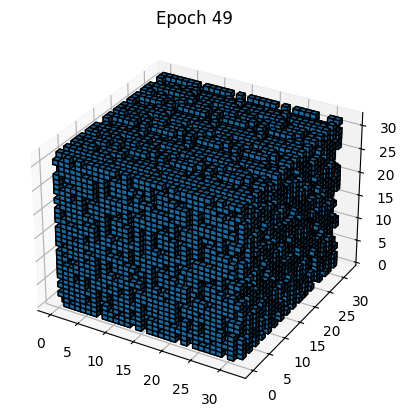

In [16]:
# Entrenamos por ejemplo con 50 épocas y un batch_size de 32
EPOCHS = 50
batch_size = 32

for epoch in range(EPOCHS):
    print(f"Época {epoch + 1}/{EPOCHS}")

    # Genera ruido aleatorio para crear volúmenes falsos
    noise = np.random.normal(0, 1, (batch_size, LATENT_DIM))

    # Crea volúmenes falsos con el generador
    fake_voxels = generator(noise, training=True)

    # Obtenemos valores reales
    real_voxels = np.random.rand(batch_size, final_resolution, final_resolution, final_resolution, 1)

    # Etiquetas realies y falsas
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    # Entrena el discriminador
    with tf.GradientTape() as disc_tape: # Crea un contexto de gradiente para calcular la pérdida del discriminador.
        # Obtiene las predicciones del discriminador para las imágenes reales.
        real_output = discriminator(real_voxels, training=True)
        # Obtiene las predicciones del discriminador para las imágenes falsas/generadas.
        fake_output = discriminator(fake_voxels, training=True)
        # Calcula la pérdida del discriminador para las imágenes reales.
        disc_loss_real = cross_entropy(real_labels, real_output)
        # Calcula la pérdida del discriminador para las imágenes generadas (fake).
        disc_loss_fake = cross_entropy(fake_labels, fake_output)
        # Suma ambas pérdidas para obtener la pérdida todal del discriminador.
        disc_loss = disc_loss_real + disc_loss_fake

    # Calcula los gradientes de la pérdida con respecto a las variables entrenables del discriminador
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Aplica los gradientes para actualizar los pesos del discriminador.
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Genera ruido nuevamente para entrenar el generador
    noise = np.random.normal(0, 1, (batch_size, LATENT_DIM))

    # Entrena el generador
    with tf.GradientTape() as gen_tape: # Crea un contexto de gradiente para calcular la pérdida del generador.
        # Crea imágenes falsas con el generador
        fake_voxels = generator(noise, training=True)
        # Evalúa las imágenes generadas con el discriminador (sin actualizar los pesos).
        fake_output = discriminator(fake_voxels, training=False)
        # Calcula la pérdida del generador intentando "engañar" al discriminador.
        gen_loss = cross_entropy(real_labels, fake_output)

    # Calcula los gradientes de la pérdida con respecto a las variables entrenables del generador.
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Aplica los gradientes para actualizar los pesos del generador.
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    # Muestra la pérdida de cada red neuronal
    print(f"Pérdida del discriminador: {disc_loss.numpy()}, Pérdida del generador: {gen_loss.numpy()}")

    if epoch % 25 == 0 or epoch == EPOCHS - 1:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.voxels(fake_voxels[0, :, :, :, 0] > 0.5, edgecolor='k')
        plt.title(f"Epoch {epoch + 1}")
        plt.show()